In [54]:
import numpy as np
import pandas as pd

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
        
from keras import backend as K
from keras.preprocessing.image import load_img, save_img, img_to_array
from keras.applications import vgg19
from keras.models import Model
import keras
from tensorflow.keras import models
import tensorflow.compat.v1 as tf

from tqdm import tqdm

import time

from scipy.optimize import fmin_l_bfgs_b

import matplotlib.pyplot as plt

import random

In [55]:
# tf.compat.v1.enable_eager_execution()
# K.clear_session()
# tf.compat.v1.reset_default_graph()
tf.disable_v2_behavior()

In [56]:
dirr_style = '../input/best-artworks-of-all-time/images/images/'
dirr_photo = '../input/image-classification/validation/validation/travel and adventure/'
# dirr_photo = '../input/image-classification/images/images/travel and  adventure/'

dirr_folder = sorted(os.listdir('../input/image-classification/validation/validation/travel and adventure/'))
# dirr_folder = sorted(os.listdir('../input/image-classification/images/images/travel and  adventure/'))

num = 4
image_path = os.path.join(dirr_photo, dirr_folder[num])
style_path = dirr_style + 'Vincent_van_Gogh/Vincent_van_Gogh_368.jpg'

In [57]:
image_path

'../input/image-classification/validation/validation/travel and adventure/13.jpg'

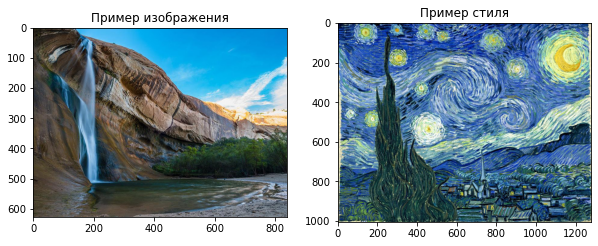

In [58]:
fig = plt.figure(figsize=(10, 8))

fig.add_subplot(1, 2, 1)
plt.title('Пример изображения')
im = load_img(image_path)
plt.imshow(im)

fig.add_subplot(1, 2, 2)
plt.title('Пример стиля')
im = load_img(style_path)
plt.imshow(im)

plt.show()

In [59]:
width, height = load_img(image_path).size

img_height = 400
img_width = 500
# img_width = int(width * img_height / height)
(width, height), (img_width, img_height)

((840, 628), (500, 400))

In [60]:
width / img_width, height / img_height

(1.68, 1.57)

In [61]:
def preprocess_image(model, image_path, rows, cols):
    img = load_img(image_path, target_size=(rows, cols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = model.preprocess_input(img)
    return img

def deprocess_image(x):
    # центрирование
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # в RGB из BGR
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [62]:
image = K.variable(preprocess_image(vgg19, image_path, img_height, img_width))
style = K.variable(preprocess_image(vgg19, style_path, img_height, img_width))
combination_image = K.placeholder((1, img_height, img_width, 3))

In [63]:
type(image), type(combination_image)

(tensorflow.python.ops.resource_variable_ops.ResourceVariable,
 tensorflow.python.framework.ops.Tensor)

In [64]:
# конкатенированный тензор из трёх фото
input_tensor = K.concatenate([image, style, combination_image], axis=0)

# модель
model = vgg19.VGG19(input_tensor=input_tensor, weights='imagenet', include_top=False)

In [65]:
combination_image

<tf.Tensor 'Placeholder_66:0' shape=(1, 400, 500, 3) dtype=float32>

In [66]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

In [67]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

In [68]:
def total_variation_loss(x):
    a = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1, :])
    b = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [69]:
# отображение названий слоёв в тензоры 
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# название слоя для функции потерь содержимого
content_layer = 'block5_conv2'

# названия слоёв для функции потерь стиля
style_layers = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1'
]

In [70]:
outputs_dict

{'input_3': <tf.Tensor 'concat_2:0' shape=(3, 400, 500, 3) dtype=float32>,
 'block1_conv1': <tf.Tensor 'block1_conv1_2/Relu:0' shape=(3, 400, 500, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2_2/Relu:0' shape=(3, 400, 500, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool_2/MaxPool:0' shape=(3, 200, 250, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1_2/Relu:0' shape=(3, 200, 250, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2_2/Relu:0' shape=(3, 200, 250, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool_2/MaxPool:0' shape=(3, 100, 125, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1_2/Relu:0' shape=(3, 100, 125, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2_2/Relu:0' shape=(3, 100, 125, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3_2/Relu:0' shape=(3, 100, 125, 256) dtype=float32>,
 'block3_conv4': <tf.Tensor 'block3_conv4_2/Relu:0' shape=(3, 100, 125, 256) dtype=float3

In [71]:
lay = outputs_dict[content_layer]
lay

<tf.Tensor 'block5_conv2_2/Relu:0' shape=(3, 25, 31, 512) dtype=float32>

In [72]:
# веса для взвешенной суммы функций потерь
total_variation_weight = 1e-4
style_weight = 1.
content_weight = 0.025

Про loss = loss + ...

https://stackoverflow.com/questions/65705507/variable-value-not-supported-problem-python

In [73]:
# потеря
loss = K.variable(0.)

# shape слоя потерь содержимого
layer_features = outputs_dict[content_layer]

# исходное изображение - первое
target_image_features = layer_features[0, :, :, :]

# полученное изображение (которое хотим приблизить) - третье
combination_features = layer_features[2, :, :, :]

# потеря += потеря содержимого
loss = loss + content_weight * content_loss(target_image_features, combination_features)
# loss += content_weight * content_loss(target_image_features, combination_features)

# для каждого слоя, используемого для вычисления потерь стиля
for layer_name in style_layers:
    # shape слоя
    layer_features = outputs_dict[layer_name]
    # изображение стиля - второе
    style_reference_features = layer_features[1, :, :, :]
    # полученное изображение
    combination_features = layer_features[2, :, :, :]
    # потеря += потеря стиля для данного слоя
    loss = loss + (style_weight / len(style_layers)) * style_loss(style_reference_features, combination_features)
    
# потеря += потеря вариации (аналог регуляризации потерь)
loss = loss + total_variation_weight * total_variation_loss(combination_image)

In [74]:
combination_features

<tf.Tensor 'strided_slice_71:0' shape=(25, 31, 512) dtype=float32>

In [75]:
# градиенты сгененированного изображения относительно функции потерь
grads = K.gradients(loss, combination_image)[0]

# функция для получения потерь и градиентов
fetch_loss_and_grads = K.function([combination_image], [loss, grads])

# класс, вычисляющий значения потерь и градиентов одновременно для BFGS
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [76]:
result_prefix = 'style'
result_prefix2 = 'origin'
iterations = 5

x = preprocess_image(vgg19, image_path, img_height, img_width)
# сохранить исходное изображение (img_height, img_width)
img = deprocess_image(x[0].copy())
fname = result_prefix2 + f'_it_{num}.png'
save_img(path=fname, x=img, data_format='channels_last')

x = x.flatten()

for i in tqdm(range(iterations)):
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x, fprime=evaluator.grads, maxfun=20)

# сохранить полученное изображение
img = x.copy().reshape((img_height, img_width, 3))
img = deprocess_image(img)
fname = result_prefix + f'_it_{num}.png'
save_img(path=fname, x=img, data_format='channels_last')

100%|██████████| 5/5 [00:32<00:00,  6.51s/it]


In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 8))
list_images = [
    load_img(image_path, target_size=(img_height, img_width)),
    load_img(style_path, target_size=(img_height, img_width)),
    img
]

for ax, im in zip(axes.flatten(), list_images):
    ax.imshow(im)

In [ ]:
!zip -r files.zip ./